# 1.A

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True, 
    download=True,
    transform=ToTensor() 
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
n = np.power(np.max(training_data[0][0].shape),2)
m = torch.unique(training_data.targets).numel()
X_train = torch.zeros((len(training_data),n))
Y_train = torch.zeros((len(training_data),m))
X_test = torch.zeros((len(test_data),n))
Y_test = torch.zeros((len(test_data),m))
for i in range(len(training_data)):
    X_train[i,:] = training_data[i][0].reshape(1,n).squeeze()
    Y_train[i, training_data[i][1]] = 1
    if i < len(test_data):
        X_test[i,:] = test_data[i][0].reshape(1,n).squeeze()
        Y_test[i, test_data[i][1]] = 1

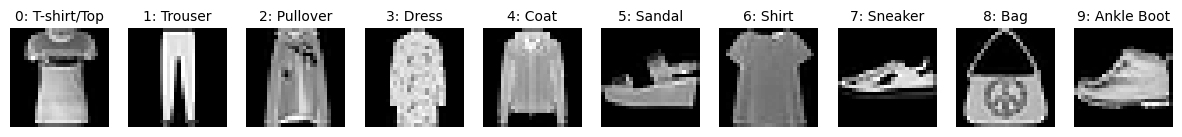

In [4]:
#torch.manual_seed(0)
targets = {
            0: "0: T-shirt/Top",
            1: "1: Trouser",
            2: "2: Pullover",
            3: "3: Dress",
            4: "4: Coat", 
            5: "5: Sandal", 
            6: "6: Shirt",
            7: "7: Sneaker",
            8: "8: Bag",
            9: "9: Ankle Boot"
            }
fig, axs = plt.subplots(1, 10)
fig.set_figwidth(15)
for i in range(10):
    x = (training_data.targets==i).nonzero(as_tuple=True)
    idx = x[0][torch.randint(1,len(x[0]),(1,1))]
    img, label = training_data[idx.item()]
    axs[i].set_title(f"{targets[label]}", fontsize=10)
    axs[i].imshow(img.squeeze(), cmap="gray")
    axs[i].axis(False)

# 1.B

In [5]:
class NeuralNetwork:
    def __init__(self, h=0):
        self.h = h # Number of hidden layers
        
    def ReLU(self,Z):
        return torch.max(Z, torch.zeros_like(Z))
    
    def softmax(self,Z):
        C = (torch.max(Z, axis = 1)).values.reshape(-1,1)
        Z = Z - C # Adding a constant value does not change the softmax output. 
                  # But it can prevent the exponential terms from going to infinity.
        Y = torch.zeros_like(Z)
        for i in range(Y.shape[0]):
            y = torch.exp(Z[i])
            Y[i]= y / torch.sum(y)
        return Y
        
    def forward(self, X, W,b):
        Z = X
        for i in range(self.h):
            Z = Z @ W[i] + b[i]
            Z = self.ReLU(Z) # ReLU activation function for hidden layers
        Z = Z @ W[-1] + b[-1]  
        return self.softmax(Z) # Softmax layer for output

In [6]:
h = 2 # Creats a Neural Network with 2 hiden layers
model = NeuralNetwork(h) 

# 1.C

In [7]:
def initialize(n, m, h):
    lw = [n] + (64 * np.ones(h, dtype=int)).tolist() + [m]
    lb = (64 * np.ones(h, dtype=int)).tolist() + [m]
    W=[]
    b=[]
    for i in range(1+h):
        W.append(0.01*torch.rand(lw[i], lw[i+1], dtype = torch.float32, device = device))
        W[i].requires_grad_()
        b.append(torch.rand(1, lb[i], requires_grad=True, dtype = torch.float32, device = device))
    return W, b

def shuffle(X, Y):
    data = torch.cat((X, Y), axis=1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:,:n]
    Y = data[:,n:]
    return X, Y

def CE(Y, Y_predicted):
    e = -Y * torch.log(Y_predicted + 1e-6) # Add 1e-6 to avoid gradient exploding
    return torch.sum(e, axis = 1).mean()

def results(X_train, Y_train, X_test, Y_test, W, b, epc):
    Y_predicted = model.forward(X_train, W, b)
    train_error = CE(Y_train, Y_predicted)
    actual_target = torch.argmax(Y_train, axis = 1)
    predicted_target = torch.argmax(Y_predicted, axis = 1)
    train_accuracy = torch.sum(actual_target == predicted_target) / len(actual_target) * 100
    Y_predicted = model.forward(X_test, W, b)
    test_error = CE(Y_test, Y_predicted)
    actual_target = torch.argmax(Y_test, axis = 1)
    predicted_target = torch.argmax(Y_predicted, axis = 1)
    test_accuracy = torch.sum(actual_target == predicted_target) / len(actual_target) * 100
    print(f"Epoch: {epc} | Test error: {test_error:.2f} | Train error: {train_error:.2f} | \
Test Accuracy: {test_accuracy:.2f} % | Train Accuracy: {train_accuracy:.2f} %")
    return test_accuracy

def train(model, X_train, Y_train, W, b, batch_size, epoch, k, n, learning_rate):
    for epc in range(epoch):
        X_train, Y_train = shuffle(X_train, Y_train) # Random shuffling
        for i in range(int(k)):
            X_batch = X_train[i*batch_size:(i+1)*batch_size,:]
            Y_batch = Y_train[i*batch_size:(i+1)*batch_size,:]
            Y_predicted = model.forward(X_batch, W, b)
            e = CE(Y_batch, Y_predicted)
            e.backward()
            for j in range(h+1):
                with torch.no_grad():
                    W[j] -= learning_rate * W[j].grad
                    b[j] -= learning_rate * b[j].grad
                    W[j].grad.zero_()
                    b[j].grad.zero_()
        test_accuracy = results(X_train, Y_train, X_test, Y_test, W, b, epc)
    return W, b, test_accuracy

In [8]:
learning_rate = 0.001
batch_size = 10
k = len(training_data.targets) / batch_size
epoch = 20
W, b = initialize(n, m, h)

In [9]:
W, b, test_accuracy = train(model, X_train, Y_train, W, b, batch_size, epoch, k, n, learning_rate)

Epoch: 0 | Test error: 2.12 | Train error: 2.12 | Test Accuracy: 22.89 % | Train Accuracy: 22.67 %
Epoch: 1 | Test error: 1.62 | Train error: 1.62 | Test Accuracy: 35.88 % | Train Accuracy: 36.01 %
Epoch: 2 | Test error: 1.36 | Train error: 1.36 | Test Accuracy: 44.94 % | Train Accuracy: 44.74 %
Epoch: 3 | Test error: 1.24 | Train error: 1.24 | Test Accuracy: 50.86 % | Train Accuracy: 51.13 %
Epoch: 4 | Test error: 1.04 | Train error: 1.04 | Test Accuracy: 58.19 % | Train Accuracy: 58.32 %
Epoch: 5 | Test error: 0.93 | Train error: 0.93 | Test Accuracy: 62.59 % | Train Accuracy: 62.66 %
Epoch: 6 | Test error: 0.86 | Train error: 0.87 | Test Accuracy: 65.74 % | Train Accuracy: 65.97 %
Epoch: 7 | Test error: 0.82 | Train error: 0.82 | Test Accuracy: 67.25 % | Train Accuracy: 67.42 %
Epoch: 8 | Test error: 0.78 | Train error: 0.78 | Test Accuracy: 70.95 % | Train Accuracy: 71.02 %
Epoch: 9 | Test error: 0.75 | Train error: 0.74 | Test Accuracy: 72.63 % | Train Accuracy: 72.79 %
Epoch: 10 

# 1.D

In [10]:
print(f"Accuracy of the model on test data after {epoch} epochs is {test_accuracy:.2f} %")

Accuracy of the model on test data after 20 epochs is 79.41 %


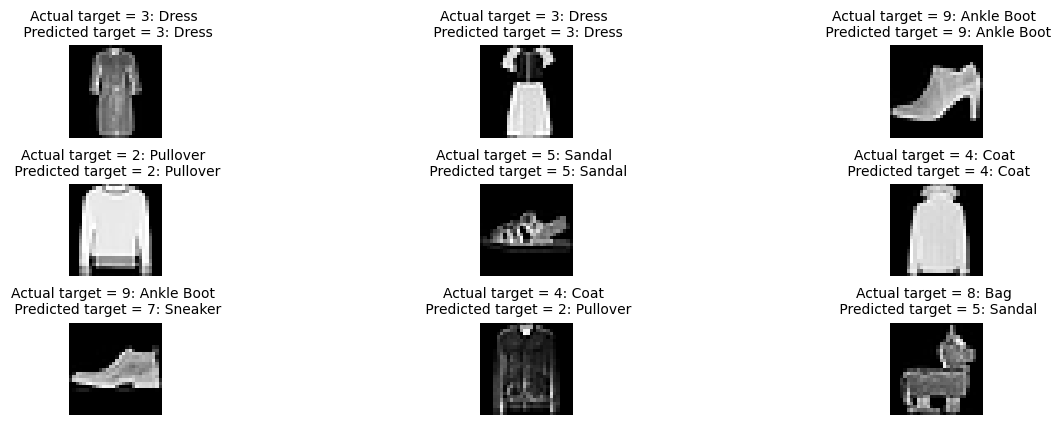

In [11]:
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(15)
for i in range(3):
    for j in range(3):
        idx = torch.randint(0, len(test_data),(1,1)).item()
        Y_predicted = model.forward(X_test[idx], W, b)
        predicted_target = torch.argmax(Y_predicted).item()
        Y = Y_test[idx]
        actual_target = torch.argmax(Y).item()
        axs[i,j].set_title(f"Actual target = {targets[actual_target]} \n \
Predicted target = {targets[predicted_target]}", fontsize=10)
        axs[i,j].imshow(X_test[idx].reshape(28 ,28), cmap="gray")
        axs[i,j].axis(False)
        plt.subplots_adjust(hspace = 0.5)